In [53]:
import os
from model import dose_response_fit, ModelPredictions, survival_to_stress
from plotting import plot_complete
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
dfs = []

for path in os.listdir("formatted_data"):
    
    
    df = pd.read_csv(f"formatted_data/{path}")
    
    
    conc = df.conc.values.astype(np.float64)
    survival = df["no stress"].values.astype(np.float64)
    hormesis = df.hormesis_concentration.iloc[0]
    
    if np.isnan(hormesis):
        hormesis = None
    
    res : ModelPredictions = dose_response_fit(conc,survival, hormesis_concentration=hormesis)
    
    title = f"{df.chemical.iloc[0]} - {df.organism.iloc[0]}"
    
    dfs.append({"title" : path[:-4], "chemical":df.chemical.iloc[0], "organism":df.organism.iloc[0], "model": res})

df = pd.DataFrame(dfs)
df.head()    

,title,chemical,organism,model
0,naeem_clothianidin_2024_agri,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....
1,ayesha-cloth_Clothianidin_2021_agricultural,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....
2,naeem-esf_esfenvalerate_2024,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....
3,imrana_cu_2024,Copper,Daphnia magna,ModelPredictions(concentration_curve=array([1....
4,imrana_food_2024,Food deprevation,Daphnia magna,ModelPredictions(concentration_curve=array([ ...


In [26]:
df.chemical.value_counts()

chemical
Clothianidin        6
Esfenvalerate       3
Copper              2
Food deprevation    1
NaCl                1
Name: count, dtype: int64

In [27]:
def compute_normalised_curve(model : ModelPredictions):
    
    x = np.linspace(model.lc1, model.lc99, 1000)
    
    return model.model(x) * 100


df["normed_curves"] = df.model.apply(compute_normalised_curve)

df["stress"] = df.normed_curves.apply(lambda x: survival_to_stress(x / 100))

In [14]:
len(df.normed_curves.iloc[0])

1000

/tmp/ipykernel_91019/1759605342.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {chemical: color for chemical, color in zip(chemicals, plt.cm.get_cmap('tab10').colors)}


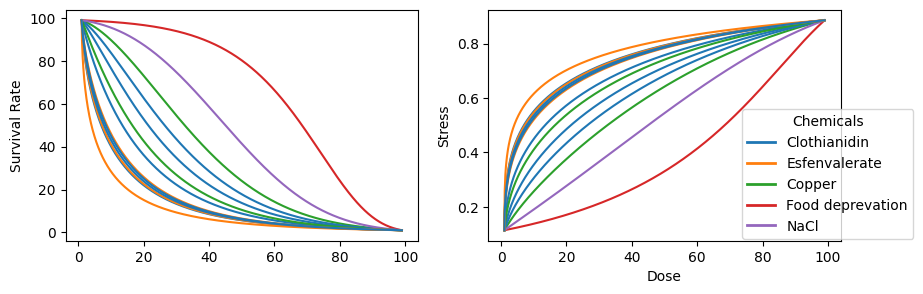

In [42]:
chemicals = df['chemical'].unique()
color_map = {chemical: color for chemical, color in zip(chemicals, plt.cm.get_cmap('tab10').colors)}

# Plot each chemical with the assigned color
fig = plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
for col, row in df.iterrows():
    plt.plot(np.linspace(1, 99, 1000), row['normed_curves'], color=color_map[row['chemical']])

plt.ylabel('Survival Rate')
plt.subplot(1,2,2)
for col, row in df.iterrows():
    plt.plot(np.linspace(1, 99, 1000), row.stress, color=color_map[row['chemical']])


handles = [plt.Line2D([0], [0], color=color_map[chem], lw=2) for chem in chemicals]
labels = [chem for chem in chemicals]
plt.legend(handles, labels, title="Chemicals", bbox_to_anchor = (0.7,0.6))

plt.xlabel('Dose')
plt.ylabel('Stress')
plt.show()

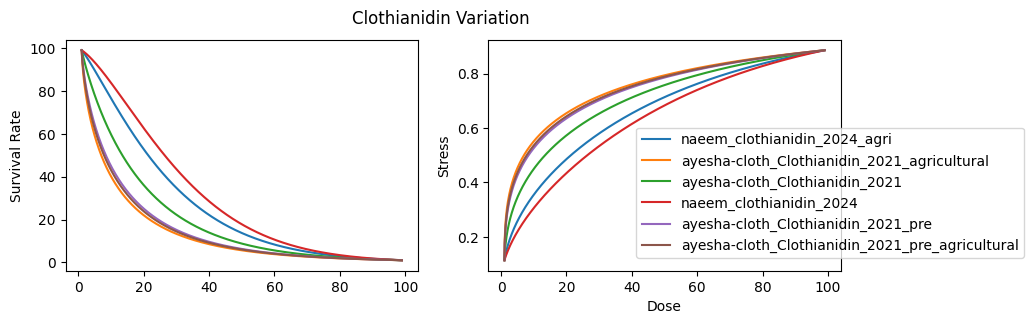

In [52]:
fig = plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
for col, row in df.query("chemical == 'Clothianidin'").iterrows():
    plt.plot(np.linspace(1, 99, 1000), row['normed_curves'], label = row.title)

plt.ylabel('Survival Rate')
plt.subplot(1,2,2)
for col, row in df.query("chemical == 'Clothianidin'").iterrows():
    plt.plot(np.linspace(1, 99, 1000), row.stress, label = row.title)

plt.legend(bbox_to_anchor = (0.4,.65))
plt.xlabel('Dose')
plt.ylabel('Stress')
plt.suptitle("Clothianidin Variation")
plt.show()

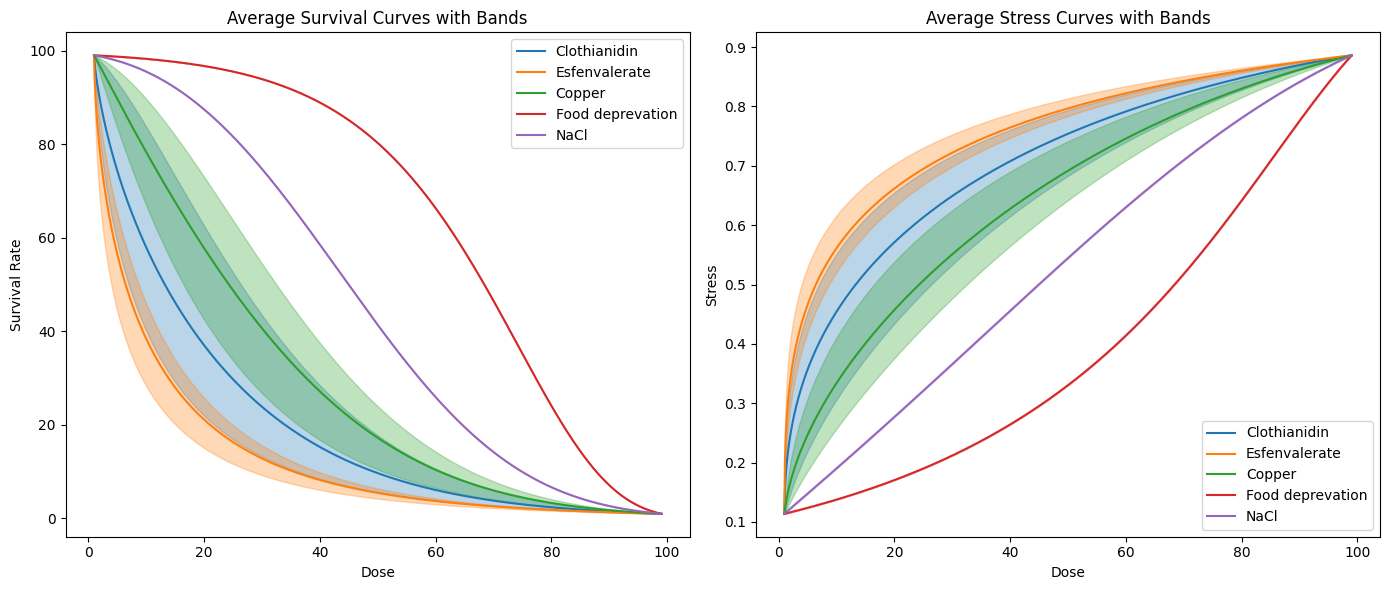

In [58]:

# Create a DataFrame to store all curves for averaging
curves_df = pd.DataFrame()
curves_df['dose'] = np.linspace(1, 99, 1000)

# Compute normalized curves and stress for each model
for index, row in df.iterrows():
    model = row['model']
    normed_curve = compute_normalised_curve(model)
    stress_curve = survival_to_stress(normed_curve / 100)
    curves_df[f"{row['chemical']}_survival_{index}"] = normed_curve
    curves_df[f"{row['chemical']}_stress_{index}"] = stress_curve

# Plot average survival and stress curves with bands
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for chemical in chemicals:
    survival_columns = [col for col in curves_df.columns if f"{chemical}_survival" in col]
    stress_columns = [col for col in curves_df.columns if f"{chemical}_stress" in col]
    
    avg_survival = curves_df[survival_columns].mean(axis=1)
    min_survival = curves_df[survival_columns].min(axis=1)
    max_survival = curves_df[survival_columns].max(axis=1)
    
    avg_stress = curves_df[stress_columns].mean(axis=1)
    min_stress = curves_df[stress_columns].min(axis=1)
    max_stress = curves_df[stress_columns].max(axis=1)
    
    # Plot survival
    axs[0].plot(curves_df['dose'], avg_survival, label=chemical, color=color_map[chemical])
    axs[0].fill_between(curves_df['dose'], min_survival, max_survival, color=color_map[chemical], alpha=0.3)
    
    # Plot stress
    axs[1].plot(curves_df['dose'], avg_stress, label=chemical, color=color_map[chemical])
    axs[1].fill_between(curves_df['dose'], min_stress, max_stress, color=color_map[chemical], alpha=0.3)

# Set titles and labels
axs[0].set_title('Average Survival Curves with Bands')
axs[0].set_xlabel('Dose')
axs[0].set_ylabel('Survival Rate')
axs[0].legend()

axs[1].set_title('Average Stress Curves with Bands')
axs[1].set_xlabel('Dose')
axs[1].set_ylabel('Stress')
axs[1].legend()

plt.tight_layout()
plt.show()
